<a href="https://colab.research.google.com/github/dsnnaveen/NYC-Taxi-Trip-Time-Preciction/blob/main/NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [1]:
pip install haversine

In [2]:
# Importing the Neccessary libraries
# from sklearn.linear_model import Lasso
# from sklearn.linear_model import Ridge
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from datetime import datetime
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor
from haversine import haversine
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# mouting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# read the csv file and loading into dataframe
df = pd.read_csv('/content/drive/MyDrive/AB Capstone Projects data files/REGRESSION/NYC Taxi Data.csv')

In [5]:
#checking the data
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [6]:
df.shape

(1458644, 11)

There are 1458644 rows and 11 columns

In [7]:
# Checking the features present in our dataset
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [8]:
# Checking  Information about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


Summary
* Passenger_count, Vendor_id and trip_duration are having integer value.
* pickup_datetime,dropoff_datetime is a datetime varriable
* pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude are real numbers having float as data type
*store_and_fwd_flag and Id belongs to a string data type.

NAN or Missing Values

It is wise to check for any missing value present in our dataset as many modelling procedures may break down. if there's any missing value present in our dataset the corresponding rows will either have to be removed completely from dataset or the values need to be estimated somehow


In [9]:
#  Checking   NAN values present in our dataset
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Here we see that "id" is insignificant for our analysis so we drop that feature

In [10]:
# Dropping the id 
df.drop('id', axis = 1, inplace = True)

In [11]:
# checking correlation
df.corr()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
vendor_id,1.000000,0.287415,0.007820,0.001742,0.001528,0.004496,0.020304
passenger_count,0.287415,1.000000,0.002169,-0.005125,-0.000343,-0.002762,0.008471
pickup_longitude,0.007820,0.002169,1.000000,0.022568,0.783582,0.100190,0.026542
pickup_latitude,0.001742,-0.005125,0.022568,1.000000,0.114884,0.494038,-0.029204
dropoff_longitude,0.001528,-0.000343,0.783582,0.114884,1.000000,0.124873,0.014678
dropoff_latitude,0.004496,-0.002762,0.100190,0.494038,0.124873,1.000000,-0.020677
trip_duration,0.020304,0.008471,0.026542,-0.029204,0.014678,-0.020677,1.000000


One idea to visualise the trip duration distribution

kde plot is kernel dencity estimation is used for univariate and bivariate analysis it is analogus to histogram

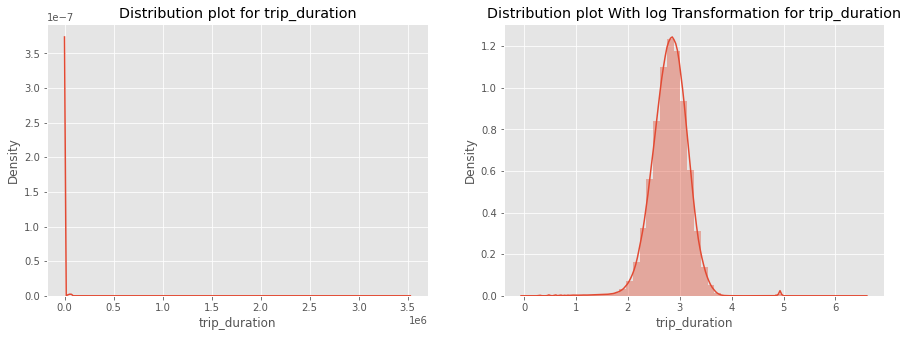

In [12]:
#Checking the distribution of dependent variable
plt.figure(figsize=[15,5])
plt.style.use('ggplot')
plt.subplot(121)
sns.kdeplot((df['trip_duration']))
plt.title("Distribution plot for trip_duration")
plt.subplot(122)
sns.distplot(np.log10(df['trip_duration']))
plt.title("Distribution plot With log Transformation for trip_duration")
plt.show()


From the above graph we see the distribution is highly positively skewed. So we have taken apply the log tranformation to the feature and checked the distribution again. Now, It looks more like normal distribution. Also, From the above graph we there are very few large value present known as oulier which result in this distribution

Text(0, 0.5, 'trip duration')

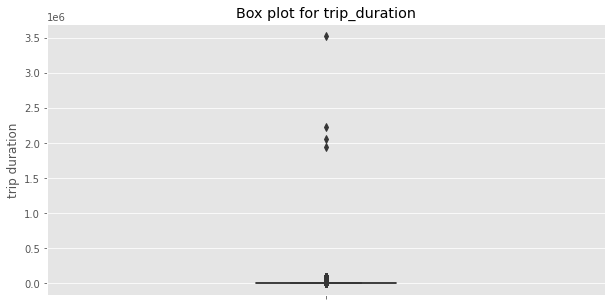

In [13]:
#checking the outlier present in our dataset.
plt.figure(figsize=[10,5])
sns.boxplot(y='trip_duration',data=df,width=0.25,palette='colorblind')
plt.title("Box plot for trip_duration")
plt.ylabel("trip duration")

Checking consitency of trip_duration

from the box plot we see that there are few outlier having very large value. we have to remove those outlier. but first let check the consitency of feature "trip duration". To do so we calculate the difference between pick and dropoff time. 

In [14]:
# creating a function that will out trip duration from pick and dropoff time
def calculate_trip_duration(pickup,dropoff):
    return (dropoff-pickup).total_seconds()

In [ ]:
# creating a feature which stores this calculated trip duration
# apply is used to apply the function in every row of the data frame
df['calculate_trip_duration']=df.apply(lambda x: calculate_trip_duration(x['pickup_datetime'],x['dropoff_datetime']),axis=1)

In [ ]:
df['calculate_trip_duration']
#  print(a)
#  type(a)

In [ ]:
df['trip_duration']

In [ ]:
# checking for consistency by comparing trip duration with calculated trip duration
# value_counts for retrun the count of  each unique values present in the series in simple terms how many times each value present in the series
# How many times unique values occured or particular values occured
(df['calculate_trip_duration']==df['trip_duration']).value_counts()

Here, we see that there the trip duration is consistent with the calculated trip duration. so, this large value are purely an outlier.

In [19]:
# Dropping the feature created 
df.drop(['calculate_trip_duration'],axis=1,inplace=True)

KeyError: ignored

To checked for outlier we segregate our dependent variable into different categories i.e trip whose duration is less then 1min, within 10mins,within hour,within day, within two day and more than two day

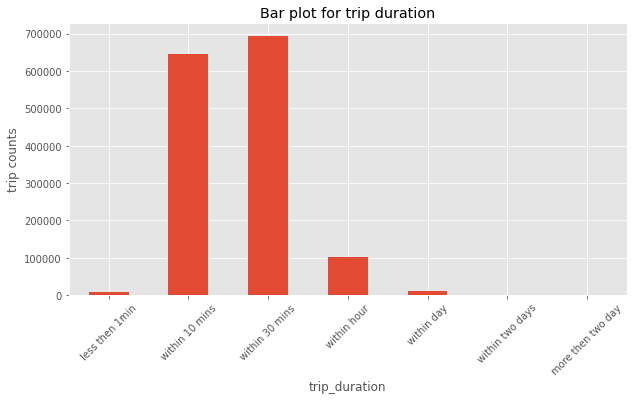

In [20]:
# segregrating the dependent variable into different categories.
plt.figure(figsize=[10,5])
labels=['less then 1min','within 10 mins','within 30 mins','within hour','within day','within two days','more then two day']
df.groupby(pd.cut(df['trip_duration'],bins=[0,60,600,1800,3600,86400,86400*2,10000000],labels=labels))['trip_duration'].count().plot(kind='bar',fontsize=10)
plt.title("Bar plot for trip duration")
plt.ylabel("trip counts")
# plt.ylabel("trip duration")
plt.xticks(rotation=45)
plt.show()


we see that majority of the data lies between 10min to 1 hour. To find the lower and upper limit for our trip duration. we calculate whiskers. Q1-1.5(IQR) and Q3+1.5(IQR)

In [ ]:
# finding lower and upper  for trip_duration
percentile_q1_trip_duration = np.percentile(df['trip_duration'],25)
percentile_q2_trip_duration = np.percentile(df['trip_duration'],50)
percentile_q3_trip_duration = np.percentile(df['trip_duration'],75)
iqr=percentile_q3_trip_duration - percentile_q1_trip_duration
lower_limit_outlier_trip_duration=percentile_q1_trip_duration-1.5*iqr
upper_limit_outlier_trip_duration=percentile_q3_trip_duration+1.5*iqr
print("lower limit for outlier  :",lower_limit_outlier_trip_duration)
print("Upper limit for outlier  :",upper_limit_outlier_trip_duration)

In [22]:
# filtering the data taking lower limit as 0 as duration can't be negative
df=df[(df['trip_duration']>0)&(df['trip_duration']<3600)]
df.shape

(1446310, 10)

In [23]:
df['trip_duration']

0           455
1           663
2          2124
3           429
4           435
           ... 
1458639     778
1458640     655
1458641     764
1458642     373
1458643     198
Name: trip_duration, Length: 1446310, dtype: int64

In [25]:
df.shape

(1446310, 10)

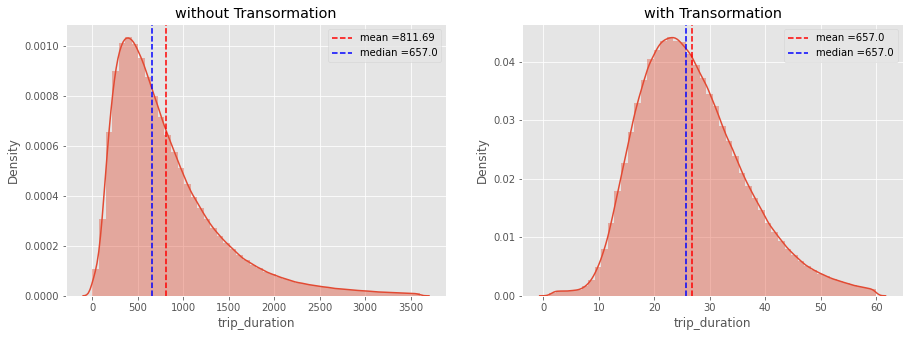

In [24]:
# checking the distribution of the trip_duration after filtering
fig=plt.figure(figsize=[15,5])
plt.style.use('ggplot')
x=df['trip_duration']
y=np.sqrt(df['trip_duration'])
plt.subplot(121)
sns.distplot(x)
ax=fig.gca()
ax.axvline(x.mean(),color='red',linestyle='dashed',label='mean ='+str(round(x.mean(),2)))
ax.axvline(x.median(),color='blue',linestyle='dashed',label='median ='+str(round(x.median(),2)))
ax.set_title('without Transormation')
plt.legend(loc='upper right')
plt.subplot(122)
sns.distplot(y)
ax=fig.gca()
ax.axvline(y.mean(),color='red',linestyle='dashed',label='mean ='+str(round(x.median(),2)))
ax.axvline(y.median(),color='blue',linestyle='dashed',label='median ='+str(round(x.median(),2)))
plt.legend(loc = 'upper right')
ax.set_title('with Transormation')
fig.show()

In [26]:
# creating a function to calculate distance based on haversine formula
def Distance(lat1,lat2,lon1,lon2):
    a=(lat1,lon1)
    b=(lat2,lon2)
    return haversine(a,b)

In [27]:
# Calculating haversine distance and dropping geographical coordinates.
df['distance']=df.apply(lambda x:  Distance(x['pickup_latitude'],x['dropoff_latitude'],x['pickup_longitude'],x['dropoff_longitude']),axis=1)
df.drop(['pickup_latitude','dropoff_latitude','pickup_longitude','dropoff_longitude'],axis=1,inplace=True)

In [28]:
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,store_and_fwd_flag,trip_duration,distance
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,N,455,1.498523
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,N,663,1.805510
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,N,2124,6.385107
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,N,429,1.485500
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,N,435,1.188590


count    1.446310e+06
mean     3.336956e+00
std      4.081384e+00
min      0.000000e+00
25%      1.227048e+00
50%      2.078488e+00
75%      3.812916e+00
max      1.240910e+03
Name: distance, dtype: float64


Text(0, 0.5, 'Distance')

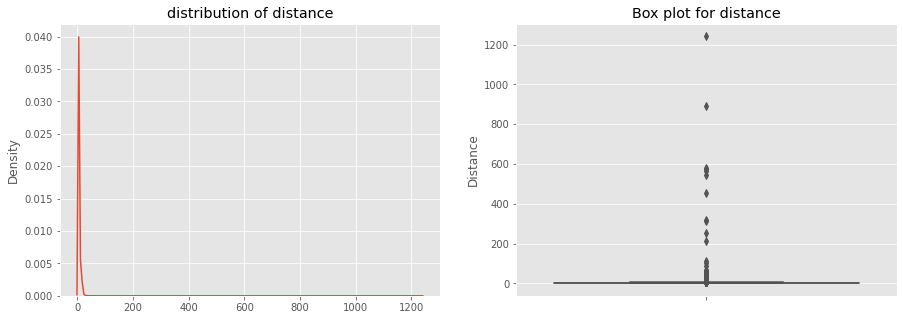

In [29]:
# checking the summary, dustribution and outlier for distance variable
print(df.distance.describe())
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.kdeplot(df['distance'].values).set_title("distribution of distance");
plt.subplot(122)
sns.boxplot(data=df,y='distance').set_title("Box plot for distance")
plt.ylabel("Distance")

To checked for outlier we segregate distance into different categories i.e trip whose distance is less then 0.1 km, within 10 km ,within 50 km and above 100 km

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

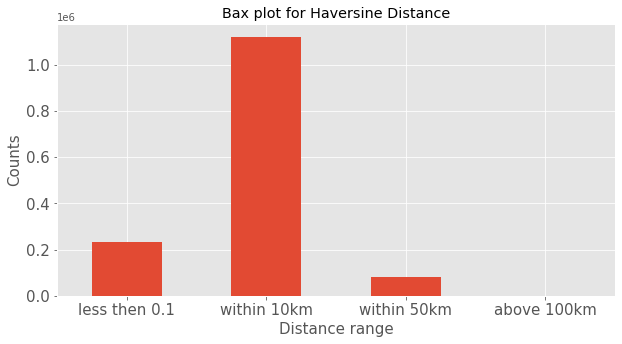

In [30]:
# segregating the distance variable into different distance ranges
fig=plt.figure(figsize=[10,5])
labels=['less then 0.1','within 10km','within 50km','above 100km']
df.groupby(pd.cut(df.distance,bins=[0.1,1,10,50,5000],labels=labels))['distance'].count().plot(kind='bar',fontsize=15)
plt.title("Bax plot for Haversine Distance")
plt.xlabel('Distance range', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.xticks(rotation=0)

we see that majority of the data lies between within 0.1 km to within 50 km. To find the lower and upper limit for ditsance. we calculate whiskers. Q1-1.5(IQR) and Q3+1.5(IQR) 

In [31]:
# finding lower and upper  for distance
percentile_q1 = np.percentile(df['distance'],25)
percentile_q2 = np.percentile(df['distance'],50)
percentile_q3 = np.percentile(df['distance'],75)
iqr=percentile_q3 - percentile_q1
lower_limit_outlier=percentile_q1-1.5*iqr
upper_limit_outlier=percentile_q3+1.5*iqr
print("lower limit for outlier  :",lower_limit_outlier)
print("Upper limit for outlier  :",upper_limit_outlier)

lower limit for outlier  : -2.651754230588305
Upper limit for outlier  : 7.6917176270841665


In [32]:
# filtering the data taking lower limit as 0 as distance can't be negative
df=df[df['distance']<50]
df.shape

(1446279, 7)

We have given pickup datetime variable. we can utilize this feature by extracting pikup day month, weekday and hour.

In [33]:
# Creating month, weekday and hour from pickup datetime variable and dropping pickup_datetime and dropp_off datetime. 
df['month'] = df.pickup_datetime.dt.month_name()
df['weekday'] = df.pickup_datetime.dt.day_name()
df['pickup_hour'] = df.pickup_datetime.dt.hour
df.drop(['pickup_datetime','dropoff_datetime'],axis=1,inplace=True)
df.head()

AttributeError: ignored

Categorical Feature Analysis:

In [ ]:
# Visualizing the categorical variable in our data
categorical_variable=set(df.columns)-{'dropoff_datetime','dropoff_latitude','dropoff_longitude','distance', 'pickup_datetime','pickup_latitude','pickup_longitude', 'trip_duration'}
fig=plt.figure(figsize=[60,20])
for i,col in enumerate(categorical_variable):
  plt.subplot(2,3,i+1)
  sns.set()
  sns.countplot(data=df,x=col).set_title(col,fontsize=25)
  plt.xlabel(col, fontsize=25)
  plt.ylabel('counts', fontsize=25)
  plt.tick_params(labelsize=20);

we relate server connection and disconnection associated with trip distance. higher trip distance means it is outside the coverage range of server. we see that the feature "store_and_fwd_flag"  has majority of value in N category. This indicates majority of the trip happened when trip is of shorter distance where vehicle is connected to vendor server.Only, few trip are happened at far away distance where server not connected. there is no significans to use this feature. so we drop it from our dataset

In [ ]:
# dropping the feature store_and_fwd_flag
df.drop('store_and_fwd_flag',axis=1,inplace=True)

Vendor id 2 has more trips than vendor id 1

we, also see that the feature "passenger count" has value between 0 to 9. Since there is no trip without passenger. we suspect passenger count zero to be a falsy value and removed it from our data set.

In [ ]:
# finding lower and upper  for passenger count
percentile_q1_passenger_count = np.percentile(df['passenger_count'],25)
percentile_q2_passenger_count = np.percentile(df['passenger_count'],50)
percentile_q3_passenger_count = np.percentile(df['passenger_count'],75)
iqr=percentile_q3_passenger_count - percentile_q1_passenger_count
lower_limit_outlier_passenger_count=percentile_q1_passenger_count-1.5*iqr
upper_limit_outlier_passenger_count=percentile_q3_passenger_count+1.5*iqr
print("lower limit for outlier  :",lower_limit_outlier_passenger_count)
print("Upper limit for outlier  :",upper_limit_outlier_passenger_count)

Here, upper limit comes out to be 3.5. Since, 3.5 doesn't signify anything. so we round of the value to 4

In [ ]:
# filtering the data based on passenger_count lower and upper values
df=df[(df['passenger_count']>0)&(df['passenger_count']<round(upper_limit_outlier_passenger_count))]
df.shape

In [ ]:
# Getting Categorical variable
categorical_variable=set(df.columns)-{'trip_duration','distance'}
categorical_variable

Here, passenger_count is also categorical variable as number of passenger doesn't impact for a certain trip

In [ ]:
# function to calculate VIF
def calvif(x):
  vif=pd.DataFrame()
  vif['feature']= x.columns
  vif['vif']=[variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
  return vif

we don't need to calculate VIF as there is only one independent numerical feature. Also, we cannot pass directly categorical variable to our model. so we have to convert it into numerical variable via one hot encoding.


In [ ]:
# creating dummies variable for categorical variables
df=pd.get_dummies(df,columns=categorical_variable)

In [ ]:
plt.figure (figsize= (16,10))
sns.heatmap(df.corr())